In [ ]:
# Standard libraries
import os
import sys
import random
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any, Sequence
import warnings
# import yaml # Thêm thư viện để xử lý config nếu cần

# Data processing
import numpy as np
import torch

# Visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ==========================================
# CONFIGURATION FOR SWIN-UNET
# ==========================================

@dataclass
class Config:
    """Cấu hình toàn bộ pipeline (Updated for Swin-UNet)"""
    
    # === Đường dẫn dữ liệu ===
    # Thư mục chứa dữ liệu gốc
    dataset_root: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/TMI2024_SFADA_GTV_Seg-20251026T074626Z-1-001/TMI2024_SFADA_GTV_Seg"
    
    # Thư mục output cho dữ liệu training (.npz) và test (.h5)
    # LƯU Ý: Swin-Unet train trên .npz (từng slice)
    output_root: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/swin_dataset_npz"
    
    # Thư mục lưu checkpoints và logs
    experiment_dir: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/swin_unet_notebook"
    
    # Đường dẫn file Pre-trained weights (BẮT BUỘC CHO SWIN-UNET)
    # Bạn cần tải file này từ repo gốc: swin_tiny_patch4_window7_224.pth
    pretrained_path: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/pretrained_ckpt/swin_tiny_patch4_window7_224.pth"

    # === Tiền xử lý dữ liệu ===
    clip_percentile: float = 0.995 # Tăng nhẹ để giữ chi tiết khối u
    train_ratio: float = 0.7
    val_ratio: float = 0.1     # Giảm val để tăng train data
    test_ratio: float = 0.2    
    
    # === Training Hyperparameters (Theo tác giả) ===
    # Tác giả dùng Batch size 24 cho GPU 12GB-24GB. Nếu OOM hãy giảm xuống 12.
    batch_size: int = 24       
    num_workers: int = 8       
    max_epochs: int = 150      # Tác giả recommend 150 epochs để Transformer hội tụ
    
    # Optimizer settings (SGD + Momentum theo paper)
    base_lr: float = 0.01      
    momentum: float = 0.9      
    weight_decay: float = 0.0001 
    
    # === Model Architecture (Swin-UNet Specs) ===
    num_classes: int = 2       # Background + Tumor
    img_size: int = 224        # BẮT BUỘC: 224x224 (Patch 4, Window 7)
    
    # Cấu hình chi tiết từ file YAML (Nhúng trực tiếp vào đây)
    model_params: Dict[str, Any] = field(default_factory=lambda: {
        "swin": {
            "patch_size": 4,
            "in_chans": 3,     # Swin gốc dùng 3 kênh (RGB), ta sẽ sửa code để nhận 1 kênh (Gray) hoặc duplicate channel
            "embed_dim": 96,
            "depths": [2, 2, 2, 2],
            "decoder_depths": [2, 2, 2, 1],
            "num_heads": [3, 6, 12, 24],
            "window_size": 7,
            "mlp_ratio": 4.,
            "qkv_bias": True,
            "qk_scale": None,
            "drop_rate": 0.0,
            "drop_path_rate": 0.2, # Quan trọng để chống overfitting
            "ape": False,          # Absolute Positional Embedding
            "patch_norm": True,
            "use_checkpoint": False, # Bật lên True nếu bị tràn VRAM (tiết kiệm bộ nhớ, tốn thời gian tính toán)
            "final_upsample": "expand_first"
        }
    })

    # === Evaluation ===
    eval_every_epoch: int = 1
    save_every_epoch: int = 50 # Chỉ lưu các mốc quan trọng để đỡ tốn ổ cứng
    patience: int = 30         # Transformer cần nhiều kiên nhẫn hơn CNN
    
    # === Misc ===
    seed: int = 1234
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Khởi tạo config
config = Config()

# Tạo các thư mục cần thiết
Path(config.output_root).mkdir(parents=True, exist_ok=True)
Path(config.experiment_dir).mkdir(parents=True, exist_ok=True)
Path("./pretrained_ckpt").mkdir(parents=True, exist_ok=True) # Tạo folder chứa weight

# Set random seed (Rất quan trọng để tái lập kết quả)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Tác giả sử dụng deterministic=True (tuy nhiên sẽ chậm hơn chút)
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_seed(config.seed)

print("✅ Swin-UNet Configuration loaded:")
print(f"   Image Size: {config.img_size}x{config.img_size} (Fixed for Window Attention)")
print(f"   Batch Size: {config.batch_size}")
print(f"   Max Epochs: {config.max_epochs}")
print(f"   Learning Rate: {config.base_lr} (SGD + Momentum)")
print(f"   Pretrained Path: {config.pretrained_path}")
print("-" * 30)

PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5090
GPU Memory: 33.67 GB
✅ Swin-UNet Configuration loaded:
   Image Size: 224x224 (Fixed for Window Attention)
   Batch Size: 24
   Max Epochs: 150
   Learning Rate: 0.01 (SGD + Momentum)
   Pretrained Path: /home/ubuntu/Documents/Source_NPC/Swin-Unet/pretrained_ckpt/swin_tiny_patch4_window7_224.pth
------------------------------


In [5]:
# ============================================================
# DATA CONVERSION UTILITIES (UPDATED FOR SWIN-UNET)
# ============================================================
from skimage.transform import resize  # Import thêm để resize ảnh

@dataclass
class CaseInfo:
    """Metadata cho một case thuộc một center cụ thể"""
    center: str
    image_path: Path
    label_path: Optional[Path]

    @property
    def base_name(self) -> str:
        name = self.image_path.name
        for suffix in reversed(self.image_path.suffixes):
            if name.endswith(suffix):
                name = name[:-len(suffix)]
        return name

    @property
    def identifier(self) -> str:
        return f"{self.center}_{self.base_name}"

def load_volume(image_path: Path, label_path: Optional[Path]) -> Tuple[np.ndarray, Optional[np.ndarray], Tuple[float, float, float]]:
    """Load NIfTI volume và trả về numpy array + spacing"""
    image_itk = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image_itk).astype(np.float32)
    spacing = image_itk.GetSpacing()

    label_array = None
    if label_path is not None and label_path.exists():
        label_itk = sitk.ReadImage(str(label_path))
        label_array = sitk.GetArrayFromImage(label_itk).astype(np.int16) # Label dùng int16 hoặc uint8
    return image_array, label_array, spacing


def intensity_clip(volume: np.ndarray, percentile: float = 0.995) -> np.ndarray:
    """Clip intensity values tại percentile để loại bỏ outliers"""
    lower = np.percentile(volume, 0.5) # Cắt cả phần dưới để loại bỏ nhiễu background quá thấp
    upper = np.percentile(volume, percentile * 100)
    return np.clip(volume, lower, upper)


def min_max_normalise(volume: np.ndarray, epsilon: float = 1e-8) -> np.ndarray:
    """
    Min-Max normalization về khoảng [0, 1] (Theo yêu cầu của tác giả Swin-UNet)
    """
    min_val = volume.min()
    max_val = volume.max()
    return (volume - min_val) / (max_val - min_val + epsilon)


def ensure_dir(path: Path) -> None:
    """Tạo thư mục nếu chưa tồn tại"""
    path.mkdir(parents=True, exist_ok=True)


def write_slice_npz(output_path: Path, image_slice: np.ndarray, label_slice: Optional[np.ndarray], target_size=(224, 224)) -> None:
    """
    Lưu một slice 2D dưới dạng .npz đã được RESIZE về 224x224.
    Đây là định dạng chuẩn để feed vào Dataset của Swin-UNet.
    """
    ensure_dir(output_path.parent)
    
    # Resize nếu kích thước chưa đúng
    if image_slice.shape != target_size:
        # order=1 (bilinear) cho ảnh, order=0 (nearest) cho label để giữ nguyên giá trị class
        image_slice = resize(image_slice, target_size, order=1, mode='constant', preserve_range=True)
        if label_slice is not None:
            label_slice = resize(label_slice, target_size, order=0, mode='constant', preserve_range=True)

    # Lưu nén .npz
    # Key 'image' và 'label' phải khớp với Dataset loader sau này
    save_dict = {'image': image_slice.astype(np.float32)}
    if label_slice is not None:
        save_dict['label'] = label_slice.astype(np.uint8) # Label segmentation nên là int
        
    np.savez_compressed(output_path, **save_dict)


def write_volume_h5(output_path: Path, image_volume: np.ndarray, label_volume: Optional[np.ndarray], 
                    spacing: Tuple[float, float, float]) -> None:
    """
    Lưu toàn bộ volume 3D dưới dạng HDF5 (Dành cho tập Test/Val để đánh giá 3D).
    Giữ nguyên kích thước gốc, không resize.
    """
    ensure_dir(output_path.parent)
    with h5py.File(output_path, "w") as f:
        # Transpose để khớp với một số format (Depth, H, W) nếu cần, hoặc giữ nguyên
        f.create_dataset("image", data=image_volume.astype(np.float32), compression="gzip")
        if label_volume is not None:
            f.create_dataset("label", data=label_volume.astype(np.int16), compression="gzip")
        f.create_dataset("voxel_spacing", data=np.asarray(spacing, dtype=np.float32), compression="gzip")


def gather_cases_by_center(dataset_root: Path) -> Dict[str, List[CaseInfo]]:
    """Quét thư mục và thu thập thông tin các cases theo center"""
    centers: Dict[str, List[CaseInfo]] = {}
    
    # Kiểm tra dataset_root có tồn tại không
    if not dataset_root.exists():
         raise FileNotFoundError(f"Dataset root not found: {dataset_root}")

    for center_dir in sorted(dataset_root.iterdir()):
        if not center_dir.is_dir():
            continue
        image_dir = center_dir / "images"
        label_dir = center_dir / "labels"
        if not image_dir.exists():
            continue
        cases: List[CaseInfo] = []
        for image_path in sorted(image_dir.glob("*.nii*")):
            label_path = label_dir / image_path.name if label_dir.exists() else None
            if label_path is not None and not label_path.exists():
                # Thử tìm file label với tên khác đôi chút nếu cần, hoặc bỏ qua
                print(f"⚠️ Missing label for {image_path}")
                continue
            cases.append(CaseInfo(center=center_dir.name, image_path=image_path, label_path=label_path))
        if cases:
            centers[center_dir.name] = cases
    if not centers:
        raise FileNotFoundError(f"No centers found in {dataset_root}")
    return centers


def split_cases_by_ratio(centers: Dict[str, List[CaseInfo]], ratios: Sequence[float], seed: int) -> Tuple[List[CaseInfo], List[CaseInfo], List[CaseInfo]]:
    """Chia cases thành train/val/test theo tỷ lệ"""
    rng = np.random.default_rng(seed)
    train_cases, val_cases, test_cases = [], [], []

    for center, cases in centers.items():
        indices = rng.permutation(len(cases))
        raw = np.array(ratios) * len(cases)
        counts = np.floor(raw).astype(int)
        remainder = len(cases) - counts.sum()
        if remainder > 0:
            order = np.argsort(raw - counts)[::-1]
            for idx in order[:remainder]:
                counts[idx] += 1
        
        train_n, val_n, test_n = counts
        train_cases.extend(cases[i] for i in indices[:train_n])
        val_cases.extend(cases[i] for i in indices[train_n:train_n + val_n])
        test_cases.extend(cases[i] for i in indices[train_n + val_n:train_n + val_n + test_n])

    return train_cases, val_cases, test_cases


print("✅ Data conversion functions updated for Swin-UNet (MinMax Norm + Resize)")

✅ Data conversion functions updated for Swin-UNet (MinMax Norm + Resize)


In [7]:
import SimpleITK as sitk
import h5py
def convert_data(config: Config, force_reconvert: bool = False):
    """
    Chuyển đổi dữ liệu NIfTI sang NPZ (Train) và HDF5 (Val/Test)
    """
    output_root = Path(config.output_root)
    training_dir = output_root / "training_set"
    val_dir = output_root / "val_set"
    test_dir = output_root / "test_set"
    
    # 1. Kiểm tra xem đã convert chưa (Check .npz cho training)
    if not force_reconvert and training_dir.exists() and len(list(training_dir.glob("*.npz"))) > 0:
        n_train = len(list(training_dir.glob("*.npz")))
        n_val = len(list(val_dir.glob("*.h5"))) if val_dir.exists() else 0
        n_test = len(list(test_dir.glob("*.h5"))) if test_dir.exists() else 0
        print(f"✅ Data already converted:")
        print(f"   Training slices (.npz): {n_train}")
        print(f"   Validation volumes (.h5): {n_val}")
        print(f"   Test volumes (.h5): {n_test}")
        return
    
    print("🔄 Starting data conversion...")
    
    # Thu thập cases
    dataset_root = Path(config.dataset_root)
    try:
        centers = gather_cases_by_center(dataset_root)
    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        return

    print(f"\n📊 Found {len(centers)} centers:")
    for center, cases in centers.items():
        print(f"   {center}: {len(cases)} cases")
    
    # Chia train/val/test
    ratios = (config.train_ratio, config.val_ratio, config.test_ratio)
    train_cases, val_cases, test_cases = split_cases_by_ratio(centers, ratios, config.seed)
    
    print(f"\n📊 Split: {len(train_cases)} train, {len(val_cases)} val, {len(test_cases)} test")
    
    # Lưu split lists
    splits_dir = output_root / "splits"
    ensure_dir(splits_dir)
    for split_name, cases in [("train", train_cases), ("val", val_cases), ("test", test_cases)]:
        with open(splits_dir / f"{split_name}.txt", "w") as f:
            for case in cases:
                # Lưu identifier (ví dụ: Center1_Case001) để dataset loader đọc sau này
                f.write(case.identifier + "\n")
    
    # --- Convert TRAINING cases (Save as 2D slices .npz + RESIZE) ---
    print("\n🔄 Converting training cases to 2D slices (.npz)...")
    ensure_dir(training_dir)
    total_slices = 0
    
    target_size = (config.img_size, config.img_size) # (224, 224)
    
    for case in tqdm(train_cases, desc="Training cases"):
        image_volume, label_volume, _ = load_volume(case.image_path, case.label_path)
        
        # Clip Intensity
        image_volume = intensity_clip(image_volume, config.clip_percentile)
        # Normalization: Dùng Min-Max theo tác giả
        image_volume = min_max_normalise(image_volume)
        
        for idx in range(image_volume.shape[0]):
            # Lưu file .npz thay vì .h5
            slice_id = f"{case.identifier}_slice_{idx:03d}.npz"
            
            # Gọi hàm write_slice_npz đã định nghĩa ở Cell trước
            # Hàm này sẽ tự động RESIZE ảnh về target_size
            write_slice_npz(
                training_dir / slice_id, 
                image_volume[idx], 
                label_volume[idx],
                target_size=target_size 
            )
            total_slices += 1
    
    print(f"   ✅ Saved {total_slices} training slices (.npz)")
    
    # --- Convert VALIDATION cases (Save as 3D volumes .h5 - Giữ nguyên size) ---
    print("\n🔄 Converting validation cases to 3D volumes (.h5)...")
    ensure_dir(val_dir)
    for case in tqdm(val_cases, desc="Validation cases"):
        image_volume, label_volume, spacing = load_volume(case.image_path, case.label_path)
        image_volume = min_max_normalise(intensity_clip(image_volume, config.clip_percentile))
        
        # Validation giữ nguyên 3D volume để đánh giá Dice Score chính xác
        write_volume_h5(val_dir / f"{case.identifier}.h5", image_volume, label_volume, spacing)
    print(f"   ✅ Saved {len(val_cases)} validation volumes")
    
    # --- Convert TEST cases (Save as 3D volumes .h5 - Giữ nguyên size) ---
    if test_cases:
        print("\n🔄 Converting test cases to 3D volumes (.h5)...")
        ensure_dir(test_dir)
        for case in tqdm(test_cases, desc="Test cases"):
            image_volume, label_volume, spacing = load_volume(case.image_path, case.label_path)
            image_volume = min_max_normalise(intensity_clip(image_volume, config.clip_percentile))
            write_volume_h5(test_dir / f"{case.identifier}.h5", image_volume, label_volume, spacing)
        print(f"   ✅ Saved {len(test_cases)} test volumes")
    
    print("\n✅ Data conversion complete!")

# Thực hiện chuyển đổi
# force_reconvert=True nếu bạn muốn chạy lại từ đầu (ví dụ do đổi config size)
convert_data(config, force_reconvert=False)

🔄 Starting data conversion...

📊 Found 3 centers:
   OA_CenterA_ano: 50 cases
   OA_CenterB_ano: 50 cases
   OA_CenterC_ano: 60 cases

📊 Split: 112 train, 16 val, 32 test

🔄 Converting training cases to 2D slices (.npz)...


Training cases: 100%|██████████| 112/112 [00:43<00:00,  2.59it/s]


   ✅ Saved 5328 training slices (.npz)

🔄 Converting validation cases to 3D volumes (.h5)...


Validation cases: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


   ✅ Saved 16 validation volumes

🔄 Converting test cases to 3D volumes (.h5)...


Test cases: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

   ✅ Saved 32 test volumes

✅ Data conversion complete!


In [9]:
# ============================================================
# AUGMENTATION & DATASET CLASSES (SWIN-UNET OPTIMIZED)
# ============================================================
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
from scipy.ndimage import zoom

class RandomGenerator(object):
    """
    Class thực hiện Augmentation giống source code của tác giả.
    Bao gồm: Random Rotation, Flip, và Resize (nếu cần).
    """
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # 1. Random Rotate & Flip (50% chance)
        if np.random.random() > 0.5:
            k = np.random.randint(0, 4)
            image = np.rot90(image, k)
            label = np.rot90(label, k)
            axis = np.random.randint(0, 2)
            image = np.flip(image, axis=axis).copy()
            label = np.flip(label, axis=axis).copy()
        
        # 2. Random Angle Rotation (50% chance)
        elif np.random.random() > 0.5:
            angle = np.random.randint(-20, 20)
            image = ndimage.rotate(image, angle, order=1, reshape=False) # order=1 for image
            label = ndimage.rotate(label, angle, order=0, reshape=False) # order=0 for label

        # 3. Safety Resize (Nếu ảnh đầu vào khác output_size)
        # Lưu ý: Vì ta đã resize lúc convert data nên bước này thường không chạy, 
        # nhưng giữ lại để an toàn như code tác giả.
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=1)
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
            
        return {'image': image, 'label': label}


class SwinNpzDataset(Dataset):
    """
    Dataset đọc file .npz cho quá trình Training (Swin-UNet)
    """
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        # Lấy danh sách file .npz
        self.files = sorted(list(self.root_dir.glob("*.npz")))
        
        if not self.files:
            # Fallback: Nếu không tìm thấy npz trực tiếp, thử tìm trong subfolder
            # Code tác giả đôi khi để trong folder con
            pass 

        print(f"Dataset created from {self.root_dir}. Total slices: {len(self.files)}")

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        file_path = self.files[idx]
        
        # Load .npz
        data = np.load(file_path)
        image = data['image'] # Shape (H, W)
        label = data['label'] # Shape (H, W)

        # Apply Augmentation (nếu có)
        if self.transform:
            sample = {'image': image, 'label': label}
            sample = self.transform(sample)
            image, label = sample['image'], sample['label']

        # Chuyển sang Tensor và thêm channel dimension
        # Swin-UNet yêu cầu input (B, C, H, W). Ở đây tạo (C, H, W) với C=1
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0) 
        label = torch.from_numpy(label.astype(np.long))

        return {
            "image": image,
            "label": label,
            "case_name": file_path.stem
        }


class H5VolumeDataset(Dataset):
    """
    Dataset cho 3D volumes (Validation/Test) - Giữ nguyên logic H5 của bạn
    """
    def __init__(self, root_dir: str):
        self.root_dir = Path(root_dir)
        self.files = sorted(self.root_dir.glob("*.h5"))
        if not self.files:
            raise FileNotFoundError(f"No HDF5 volumes found in {self.root_dir}")

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        file_path = self.files[index]
        with h5py.File(file_path, "r") as f:
            image = f["image"][:].astype(np.float32)      # (D, H, W)
            label = f["label"][:].astype(np.int64) if "label" in f else None
            
            # Kiểm tra spacing, nếu không có thì mặc định (1,1,1)
            if "voxel_spacing" in f:
                spacing = f["voxel_spacing"][:].astype(np.float32)
            else:
                spacing = np.array([1.0, 1.0, 1.0], dtype=np.float32)

        # Thêm channel dimension: [D, H, W] -> [1, D, H, W]
        # Lưu ý: Khi validate 3D, ta thường cắt slice theo trục D để đưa vào model 2D
        image_tensor = torch.from_numpy(np.ascontiguousarray(image[np.newaxis, ...]))
        label_tensor = torch.from_numpy(np.ascontiguousarray(label)).long() if label is not None else None
        
        return {
            "image": image_tensor,      # (1, D, H, W)
            "label": label_tensor,      # (D, H, W)
            "spacing": spacing,
            "name": file_path.stem,
        }

print("✅ Swin-UNet Dataset classes defined")

✅ Swin-UNet Dataset classes defined


In [10]:
# ============================================================
# SWIN-UNET ARCHITECTURE
# ============================================================
# Cài đặt thư viện bổ trợ nếu chưa có
try:
    import timm
    import einops
except ImportError:
    print("Installing timm and einops...")
    !pip install -q timm einops
    import timm
    import einops

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import copy
import logging

# --- 1. Helper Classes (Blocks, Layers) ---
# (Giữ nguyên logic từ swin_transformer_unet_skip_expand_decoder_sys.py)

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False) if dim_scale == 2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)
        return x

class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16 * dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.output_dim)
        x = self.norm(x)
        return x

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

class BasicLayer_up(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x

# --- 2. Swin Transformer System (Main Backbone + Decoder) ---

class SwinTransformerSys(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        # Encoder
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        # Decoder
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2 * int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                      int(embed_dim * 2 ** (self.num_layers - 1 - i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer == 0:
                layer_up = PatchExpand(
                    input_resolution=(patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                      patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                    dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                         input_resolution=(
                                         patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                         patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                                         depth=depths[(self.num_layers - 1 - i_layer)],
                                         num_heads=num_heads[(self.num_layers - 1 - i_layer)],
                                         window_size=window_size,
                                         mlp_ratio=self.mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop_rate, attn_drop=attn_drop_rate,
                                         drop_path=dpr[sum(depths[:(self.num_layers - 1 - i_layer)]):sum(
                                             depths[:(self.num_layers - 1 - i_layer) + 1])],
                                         norm_layer=norm_layer,
                                         upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                         use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up = norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            self.up = FinalPatchExpand_X4(input_resolution=(img_size // patch_size, img_size // patch_size),
                                          dim_scale=4, dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []
        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)
        x = self.norm(x)
        return x, x_downsample

    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x, x_downsample[3 - inx]], -1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)
        x = self.norm_up(x)
        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        if self.final_upsample == "expand_first":
            x = self.up(x)
            x = x.view(B, 4 * H, 4 * W, -1)
            x = x.permute(0, 3, 1, 2)
            x = self.output(x)
        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x, x_downsample)
        x = self.up_x4(x)
        return x

    def load_from(self, pretrained_path):
        """
        Bí thuật của tác giả: Load pretrained ImageNet (Encoder) 
        và khởi tạo weights cho Decoder bằng weights của Encoder để hội tụ nhanh.
        """
        if pretrained_path is not None and os.path.exists(pretrained_path):
            print(f"Loading pretrained model from {pretrained_path}")
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            pretrained_dict = torch.load(pretrained_path, map_location=device)
            if "model" in pretrained_dict:
                pretrained_dict = pretrained_dict['model']
                
            model_dict = self.state_dict()
            full_dict = copy.deepcopy(pretrained_dict)
            
            # Logic map weights Encoder -> Decoder
            for k, v in pretrained_dict.items():
                if "layers." in k:
                    current_layer_num = 3 - int(k[7:8])
                    current_k = "layers_up." + str(current_layer_num) + k[8:]
                    full_dict.update({current_k: v})
                    
            # Filter các key sai shape
            for k in list(full_dict.keys()):
                if k in model_dict:
                    if full_dict[k].shape != model_dict[k].shape:
                        print(f"Discarding {k} due to shape mismatch: {full_dict[k].shape} vs {model_dict[k].shape}")
                        del full_dict[k]
                        
            msg = self.load_state_dict(full_dict, strict=False)
            print("Pretrained weights loaded successfully.")
        else:
            print("No pretrained path found or file does not exist. Training from scratch.")

# --- 3. Final Wrapper Class (Kết nối với Config của bạn) ---

class SwinUnet(nn.Module):
    def __init__(self, config, zero_head=False):
        super(SwinUnet, self).__init__()
        self.num_classes = config.num_classes
        self.zero_head = zero_head
        self.config = config
        
        swin_config = config.model_params['swin']

        self.swin_unet = SwinTransformerSys(
            img_size=config.img_size,
            patch_size=swin_config['patch_size'],
            in_chans=swin_config['in_chans'],
            num_classes=self.num_classes,
            embed_dim=swin_config['embed_dim'],
            depths=swin_config['depths'],
            depths_decoder=swin_config['decoder_depths'],
            num_heads=swin_config['num_heads'],
            window_size=swin_config['window_size'],
            mlp_ratio=swin_config['mlp_ratio'],
            qkv_bias=swin_config['qkv_bias'],
            qk_scale=swin_config['qk_scale'],
            drop_rate=swin_config['drop_rate'],
            drop_path_rate=swin_config['drop_path_rate'],
            ape=swin_config['ape'],
            patch_norm=swin_config['patch_norm'],
            use_checkpoint=swin_config['use_checkpoint'],
            final_upsample=swin_config['final_upsample']
        )

    def forward(self, x):
        # Handle 1-channel MRI input -> 3-channel Swin expectation
        if x.size()[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        logits = self.swin_unet(x)
        return logits
    
    def load_pretrained(self, path):
        self.swin_unet.load_from(path)

print("✅ Swin-UNet Model defined successfully.")

✅ Swin-UNet Model defined successfully.


/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/.venv/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


🏗️ Initializing Swin-UNet model...


/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/.venv/lib/python3.13/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading pretrained model from /home/ubuntu/Documents/Source_NPC/Swin-Unet/pretrained_ckpt/swin_tiny_patch4_window7_224.pth
Pretrained weights loaded successfully.
✅ Model created successfully on cuda
   Total parameters: 27,168,228
   Trainable parameters: 27,168,228
Dataset created from /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/swin_dataset_npz/training_set. Total slices: 5328

📊 Training dataset: 5328 slices (2D)
📊 Validation dataset: 16 volumes (3D)
📊 Iterations per epoch: 222
📊 Max epochs: 150


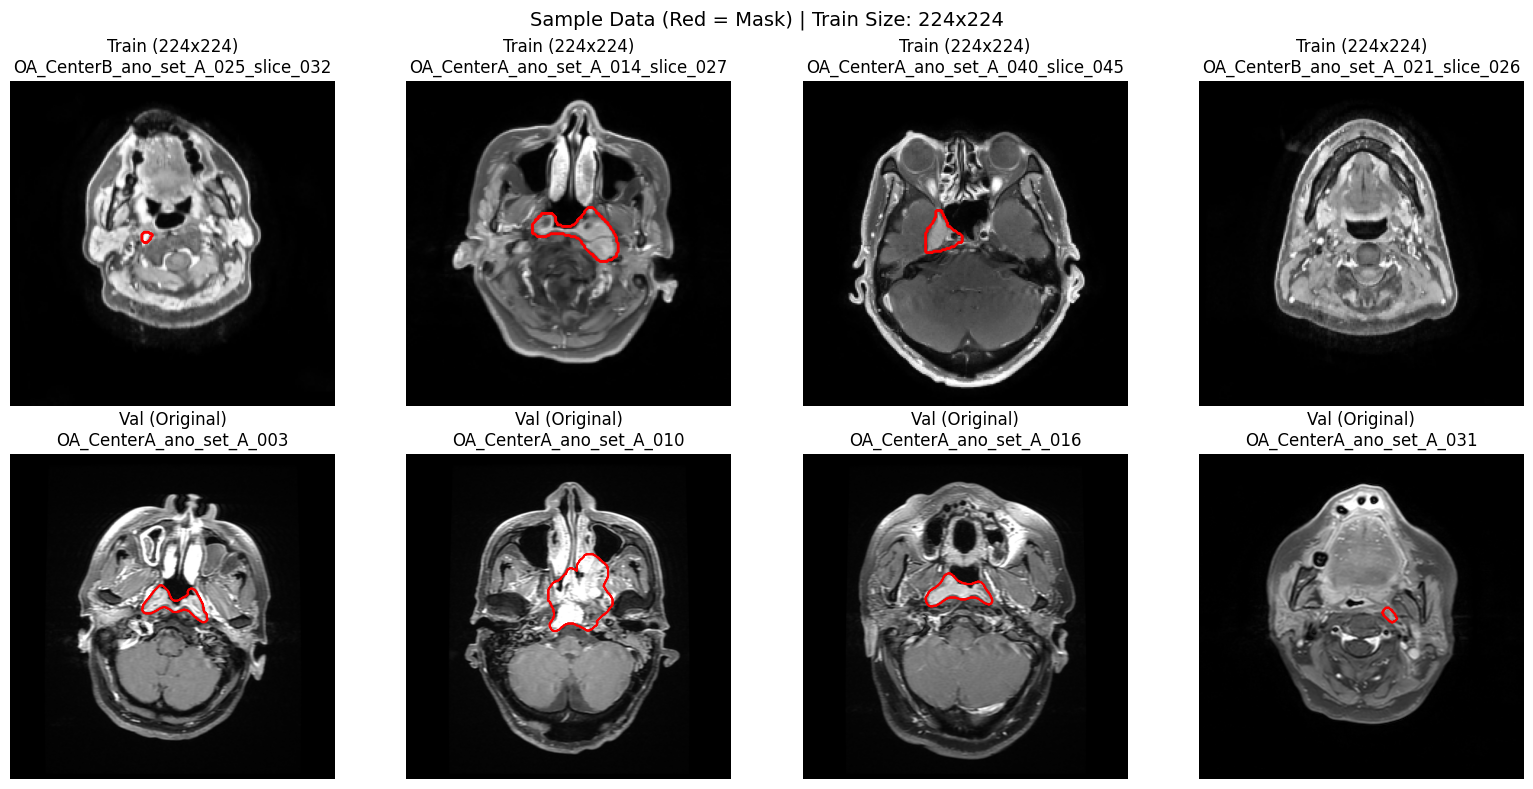

In [11]:
# ============================================================
# MODEL & DATALOADER SETUP (SWIN-UNET)
# ============================================================
from torchvision import transforms

# 1. Tạo Model Swin-UNet
print("🏗️ Initializing Swin-UNet model...")
model = SwinUnet(config, zero_head=False)
device = torch.device(config.device if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Load Pre-trained Weights (ImageNet)
# Swin Transformer cần pre-trained weights để hội tụ tốt
if os.path.exists(config.pretrained_path):
    model.load_pretrained(config.pretrained_path)
else:
    print(f"⚠️ WARNING: Pretrained path '{config.pretrained_path}' does not exist.")
    print("   The model will train from scratch (might be slower and less accurate).")
    print("   Please download 'swin_tiny_patch4_window7_224.pth' and place it in the correct folder.")

# 3. Đếm Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created successfully on {device}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# 4. Tạo Datasets & Transforms
# Tác giả sử dụng RandomGenerator bọc trong Compose
train_transform = transforms.Compose([
    RandomGenerator(output_size=[config.img_size, config.img_size])
])

# Training Dataset (.npz files)
train_dataset = SwinNpzDataset(
    root_dir=Path(config.output_root) / "training_set",
    transform=train_transform
)

# Validation Dataset (.h5 volumes)
val_dataset = H5VolumeDataset(
    root_dir=Path(config.output_root) / "val_set"
)

print(f"\n📊 Training dataset: {len(train_dataset)} slices (2D)")
print(f"📊 Validation dataset: {len(val_dataset)} volumes (3D)")

# 5. Tạo DataLoaders
def worker_init_fn(worker_id):
    random.seed(config.seed + worker_id)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
    worker_init_fn=worker_init_fn
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=1, # Validation luôn batch=1 để xử lý từng volume
    shuffle=False, 
    num_workers=1
)

print(f"📊 Iterations per epoch: {len(train_loader)}")
print(f"📊 Max epochs: {config.max_epochs}")

# 6. Visualize một vài samples để kiểm tra
# Chú ý: Swin-UNet input size cố định 224x224
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Training samples (Augmented & Resized)
for i in range(4):
    try:
        idx = np.random.randint(0, len(train_dataset))
        sample = train_dataset[idx]
        image = sample["image"].squeeze().numpy() # (1, 224, 224) -> (224, 224)
        label = sample["label"].numpy()           # (224, 224)
        
        axes[0, i].imshow(image, cmap="gray")
        # Contour label (nếu có mask)
        if label.sum() > 0:
            axes[0, i].contour(label, colors="red", linewidths=1)
            
        axes[0, i].set_title(f"Train (224x224)\n{sample['case_name']}")
        axes[0, i].axis("off")
    except Exception as e:
        print(f"Error viz train sample: {e}")

# Validation samples (Original 3D Volume)
for i in range(4):
    if i < len(val_dataset):
        sample = val_dataset[i]
        image = sample["image"].squeeze().numpy()  # (D, H, W)
        label = sample["label"].squeeze().numpy()  # (D, H, W)
        
        # Lấy slice giữa
        mid_slice = image.shape[0] // 2
        
        axes[1, i].imshow(image[mid_slice], cmap="gray")
        if label.sum() > 0:
            axes[1, i].contour(label[mid_slice], colors="red", linewidths=1)
            
        axes[1, i].set_title(f"Val (Original)\n{sample['name']}")
        axes[1, i].axis("off")

plt.suptitle(f"Sample Data (Red = Mask) | Train Size: {config.img_size}x{config.img_size}", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# ============================================================
# TRAINING LOOP & EVALUATION (FULL FIXED)
# ============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path
from scipy.ndimage import zoom
from skimage.transform import resize # Import thêm để resize an toàn

# Import metric từ medpy
try:
    from medpy import metric
except ImportError:
    print("Installing medpy...")
    !pip install -q medpy
    from medpy import metric

# --- 1. Define Helper Functions (Metrics & Loss) ---

def calculate_metric_percase(pred, gt, spacing=(1.0, 1.0, 1.0)):
    """
    Tính Dice, HD95, ASD cho 1 case.
    """
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    
    if pred.sum() > 0 and gt.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        # HD95 và ASD có thể gây lỗi nếu voxelspacing không đúng hoặc hình học phức tạp
        try:
            hd95 = metric.binary.hd95(pred, gt, voxelspacing=spacing)
        except:
            hd95 = 0.0
        try:
            asd = metric.binary.asd(pred, gt, voxelspacing=spacing)
        except:
            asd = 0.0
        return dice, hd95, asd
    elif pred.sum() > 0 and gt.sum() == 0:
        return 1, 0, 0 # False Positive (nhưng Dice quy ước là gì tùy bài toán, ở đây để 1 hoặc 0)
    else:
        return 0, 0, 0

class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        loss = 0.0
        # Tính Dice tổng hợp các class
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            loss += dice
        return loss / self.n_classes

# --- 2. Setup Loss, Optimizer, History ---

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(config.num_classes)

optimizer = optim.SGD(
    model.parameters(), 
    lr=config.base_lr, 
    momentum=config.momentum, 
    weight_decay=config.weight_decay
)

experiment_dir = Path(config.experiment_dir)
experiment_dir.mkdir(parents=True, exist_ok=True)

best_performance = 0.0
best_epoch = 0
iter_num = 0
patience_counter = 0
total_iterations = config.max_epochs * len(train_loader)

history = {
    'epoch': [], 'train_loss': [], 'lr': [], 
    'val_dice': [], 'val_hd95': []
}

print(f"🚀 Training setup complete. Max Epochs: {config.max_epochs}")

# --- 3. Start Training Loop ---

for epoch_num in range(1, config.max_epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_dice_loss = 0.0
    epoch_ce_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{config.max_epochs}", leave=True)
    
    for batch in pbar:
        images = batch["image"].to(device).float()
        labels = batch["label"].to(device).long()

        # Forward
        logits = model(images)
        loss_ce = ce_loss(logits, labels)
        loss_dice = dice_loss(logits, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track & Decay
        iter_num += 1
        epoch_loss += loss.item()
        epoch_dice_loss += loss_dice.item()
        epoch_ce_loss += loss_ce.item()
        num_batches += 1
        
        lr_ = config.base_lr * (1.0 - iter_num / total_iterations) ** 0.9
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_

        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}", 
            "Dice": f"{loss_dice.item():.4f}",
            "CE": f"{loss_ce.item():.4f}"
        })

    avg_epoch_loss = epoch_loss / num_batches
    
    # --- Validation Phase ---
    if epoch_num % config.eval_every_epoch == 0:
        model.eval()
        metric_list = []
        
        with torch.no_grad():
            for val_batch in tqdm(val_loader, desc="Validation", leave=False):
                # Lấy dữ liệu 3D (Bỏ Batch & Channel)
                image = val_batch["image"][0, 0].cpu().detach().numpy() 
                label = val_batch["label"][0].cpu().detach().numpy()
                
                prediction = np.zeros_like(label)
                
                # Slice-by-slice inference
                for ind in range(image.shape[0]):
                    slice_img = image[ind, :, :]
                    h, w = slice_img.shape
                    
                    # Resize input to 224x224
                    scale_h = config.img_size / h
                    scale_w = config.img_size / w
                    
                    slice_resized = zoom(slice_img, (scale_h, scale_w), order=1)
                    input_tensor = torch.from_numpy(slice_resized).unsqueeze(0).unsqueeze(0).float().to(device)
                    
                    # Predict
                    out = model(input_tensor)
                    out = torch.argmax(torch.softmax(out, dim=1), dim=1).squeeze().cpu().detach().numpy()
                    
                    # Resize output back to original size
                    pred_resized = zoom(out, (1/scale_h, 1/scale_w), order=0)
                    
                    # Fix kích thước nếu zoom làm lệch 1 vài pixel
                    if pred_resized.shape != (h, w):
                         pred_resized = resize(pred_resized, (h, w), order=0, mode='constant', preserve_range=True)

                    prediction[ind, :, :] = pred_resized
                
                # Calculate metric (Tumor class = 1)
                dice, hd95, asd = calculate_metric_percase(prediction == 1, label == 1)
                metric_list.append([dice, hd95, asd])
        
        # Log & Print
        metric_array = np.array(metric_list)
        dice_score = np.nanmean(metric_array[:, 0])
        hd95_score = np.nanmean(metric_array[:, 1])
        
        history['epoch'].append(epoch_num)
        history['train_loss'].append(avg_epoch_loss)
        history['lr'].append(lr_)
        history['val_dice'].append(dice_score)
        history['val_hd95'].append(hd95_score)
        
        print(f"   Epoch {epoch_num} | Loss: {avg_epoch_loss:.4f} | Val Dice: {dice_score:.4f} | HD95: {hd95_score:.2f}")

        # Checkpoint Best Model
        if dice_score > best_performance:
            best_performance = dice_score
            best_epoch = epoch_num
            patience_counter = 0
            
            best_path = experiment_dir / "swin_best_model.pth"
            torch.save({
                "epoch": epoch_num,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "dice": best_performance,
            }, best_path)
            print(f"   🌟 New best model saved! Dice: {best_performance:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print(f"   🛑 Early stopping at epoch {epoch_num}")
                break
    
    # Checkpoint Regular
    if epoch_num % config.save_every_epoch == 0:
        torch.save(model.state_dict(), experiment_dir / f"model_epoch_{epoch_num}.pth")

# End
torch.save(model.state_dict(), experiment_dir / "swin_last_model.pth")
print(f"\n✅ Training Finished. Best Dice: {best_performance:.4f} at epoch {best_epoch}")

🚀 Training setup complete. Max Epochs: 150


Epoch 1/150: 100%|██████████| 222/222 [00:10<00:00, 20.63it/s, Loss=0.1001, Dice=0.1626, CE=0.0063]


   Epoch 1 | Loss: 0.1246 | Val Dice: 0.5710 | HD95: 14.06
   🌟 New best model saved! Dice: 0.5710


Epoch 2/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0972, Dice=0.1537, CE=0.0125]


   Epoch 2 | Loss: 0.1080 | Val Dice: 0.6443 | HD95: 14.97
   🌟 New best model saved! Dice: 0.6443


Epoch 3/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0885, Dice=0.1430, CE=0.0068]


   Epoch 3 | Loss: 0.0969 | Val Dice: 0.6323 | HD95: 12.90


Epoch 4/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0821, Dice=0.1301, CE=0.0101]


   Epoch 4 | Loss: 0.0980 | Val Dice: 0.6585 | HD95: 10.44
   🌟 New best model saved! Dice: 0.6585


Epoch 5/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0830, Dice=0.1325, CE=0.0087]


   Epoch 5 | Loss: 0.0804 | Val Dice: 0.7002 | HD95: 8.06
   🌟 New best model saved! Dice: 0.7002


Epoch 6/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0652, Dice=0.1021, CE=0.0099]


   Epoch 6 | Loss: 0.0798 | Val Dice: 0.6868 | HD95: 10.43


Epoch 7/150: 100%|██████████| 222/222 [00:10<00:00, 20.74it/s, Loss=0.0618, Dice=0.0991, CE=0.0060]


   Epoch 7 | Loss: 0.0776 | Val Dice: 0.7235 | HD95: 7.55
   🌟 New best model saved! Dice: 0.7235


Epoch 8/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0555, Dice=0.0884, CE=0.0063]


   Epoch 8 | Loss: 0.0715 | Val Dice: 0.7256 | HD95: 6.70
   🌟 New best model saved! Dice: 0.7256


Epoch 9/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0555, Dice=0.0893, CE=0.0049]


   Epoch 9 | Loss: 0.0674 | Val Dice: 0.7171 | HD95: 7.46


Epoch 10/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0906, Dice=0.1490, CE=0.0031]


   Epoch 10 | Loss: 0.0654 | Val Dice: 0.7484 | HD95: 6.51
   🌟 New best model saved! Dice: 0.7484


Epoch 11/150: 100%|██████████| 222/222 [00:10<00:00, 20.63it/s, Loss=0.0541, Dice=0.0882, CE=0.0029]


   Epoch 11 | Loss: 0.0624 | Val Dice: 0.7454 | HD95: 7.94


Epoch 12/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0469, Dice=0.0748, CE=0.0049]


   Epoch 12 | Loss: 0.0586 | Val Dice: 0.7592 | HD95: 5.84
   🌟 New best model saved! Dice: 0.7592


Epoch 13/150: 100%|██████████| 222/222 [00:10<00:00, 20.68it/s, Loss=0.0542, Dice=0.0882, CE=0.0032]


   Epoch 13 | Loss: 0.0616 | Val Dice: 0.7655 | HD95: 6.11
   🌟 New best model saved! Dice: 0.7655


Epoch 14/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0493, Dice=0.0798, CE=0.0036]


   Epoch 14 | Loss: 0.0570 | Val Dice: 0.7476 | HD95: 7.08


Epoch 15/150: 100%|██████████| 222/222 [00:10<00:00, 20.64it/s, Loss=0.0634, Dice=0.1023, CE=0.0050]


   Epoch 15 | Loss: 0.0564 | Val Dice: 0.7499 | HD95: 6.74


Epoch 16/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0488, Dice=0.0789, CE=0.0037]


   Epoch 16 | Loss: 0.0565 | Val Dice: 0.7676 | HD95: 8.24
   🌟 New best model saved! Dice: 0.7676


Epoch 17/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0721, Dice=0.1179, CE=0.0035]


   Epoch 17 | Loss: 0.0527 | Val Dice: 0.7716 | HD95: 6.12
   🌟 New best model saved! Dice: 0.7716


Epoch 18/150: 100%|██████████| 222/222 [00:10<00:00, 20.65it/s, Loss=0.0576, Dice=0.0934, CE=0.0040]


   Epoch 18 | Loss: 0.0518 | Val Dice: 0.7670 | HD95: 6.29


Epoch 19/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0677, Dice=0.1114, CE=0.0022]


   Epoch 19 | Loss: 0.0543 | Val Dice: 0.7719 | HD95: 5.86
   🌟 New best model saved! Dice: 0.7719


Epoch 20/150: 100%|██████████| 222/222 [00:10<00:00, 20.74it/s, Loss=0.0523, Dice=0.0845, CE=0.0040]


   Epoch 20 | Loss: 0.0501 | Val Dice: 0.7715 | HD95: 6.20


Epoch 21/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0618, Dice=0.0996, CE=0.0052]


   Epoch 21 | Loss: 0.0483 | Val Dice: 0.7761 | HD95: 5.50
   🌟 New best model saved! Dice: 0.7761


Epoch 22/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0563, Dice=0.0923, CE=0.0025]


   Epoch 22 | Loss: 0.0471 | Val Dice: 0.7770 | HD95: 6.16
   🌟 New best model saved! Dice: 0.7770


Epoch 23/150: 100%|██████████| 222/222 [00:10<00:00, 20.86it/s, Loss=0.0643, Dice=0.1038, CE=0.0051]


   Epoch 23 | Loss: 0.0478 | Val Dice: 0.7860 | HD95: 5.42
   🌟 New best model saved! Dice: 0.7860


Epoch 24/150: 100%|██████████| 222/222 [00:10<00:00, 20.79it/s, Loss=0.0604, Dice=0.0991, CE=0.0025]


   Epoch 24 | Loss: 0.0450 | Val Dice: 0.7911 | HD95: 5.25
   🌟 New best model saved! Dice: 0.7911


Epoch 25/150: 100%|██████████| 222/222 [00:10<00:00, 20.74it/s, Loss=0.0360, Dice=0.0579, CE=0.0032]


   Epoch 25 | Loss: 0.0479 | Val Dice: 0.7704 | HD95: 5.72


Epoch 26/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0593, Dice=0.0979, CE=0.0013]


   Epoch 26 | Loss: 0.0476 | Val Dice: 0.7895 | HD95: 5.43


Epoch 27/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0275, Dice=0.0443, CE=0.0021]


   Epoch 27 | Loss: 0.0426 | Val Dice: 0.7952 | HD95: 5.18
   🌟 New best model saved! Dice: 0.7952


Epoch 28/150: 100%|██████████| 222/222 [00:10<00:00, 20.64it/s, Loss=0.1004, Dice=0.1668, CE=0.0008]


   Epoch 28 | Loss: 0.0427 | Val Dice: 0.7993 | HD95: 5.44
   🌟 New best model saved! Dice: 0.7993


Epoch 29/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0555, Dice=0.0903, CE=0.0032]


   Epoch 29 | Loss: 0.0472 | Val Dice: 0.7845 | HD95: 5.40


Epoch 30/150: 100%|██████████| 222/222 [00:10<00:00, 20.84it/s, Loss=0.0337, Dice=0.0541, CE=0.0032]


   Epoch 30 | Loss: 0.0406 | Val Dice: 0.8028 | HD95: 4.83
   🌟 New best model saved! Dice: 0.8028


Epoch 31/150: 100%|██████████| 222/222 [00:10<00:00, 20.65it/s, Loss=0.0268, Dice=0.0439, CE=0.0010]


   Epoch 31 | Loss: 0.0432 | Val Dice: 0.7969 | HD95: 5.34


Epoch 32/150: 100%|██████████| 222/222 [00:10<00:00, 20.65it/s, Loss=0.0336, Dice=0.0528, CE=0.0048]


   Epoch 32 | Loss: 0.0411 | Val Dice: 0.7898 | HD95: 5.62


Epoch 33/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0288, Dice=0.0467, CE=0.0020]


   Epoch 33 | Loss: 0.0397 | Val Dice: 0.7925 | HD95: 4.99


Epoch 34/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0299, Dice=0.0485, CE=0.0020]


   Epoch 34 | Loss: 0.0395 | Val Dice: 0.7982 | HD95: 5.19


Epoch 35/150: 100%|██████████| 222/222 [00:10<00:00, 20.66it/s, Loss=0.0498, Dice=0.0807, CE=0.0035]


   Epoch 35 | Loss: 0.0393 | Val Dice: 0.7957 | HD95: 4.78


Epoch 36/150: 100%|██████████| 222/222 [00:10<00:00, 20.62it/s, Loss=0.0282, Dice=0.0452, CE=0.0027]


   Epoch 36 | Loss: 0.0390 | Val Dice: 0.7926 | HD95: 5.38


Epoch 37/150: 100%|██████████| 222/222 [00:10<00:00, 20.64it/s, Loss=0.0388, Dice=0.0625, CE=0.0034]


   Epoch 37 | Loss: 0.0392 | Val Dice: 0.7989 | HD95: 5.18


Epoch 38/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0345, Dice=0.0562, CE=0.0019]


   Epoch 38 | Loss: 0.0401 | Val Dice: 0.7911 | HD95: 5.43


Epoch 39/150: 100%|██████████| 222/222 [00:10<00:00, 20.83it/s, Loss=0.0391, Dice=0.0620, CE=0.0047]


   Epoch 39 | Loss: 0.0383 | Val Dice: 0.7987 | HD95: 4.60


Epoch 40/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0280, Dice=0.0457, CE=0.0015]


   Epoch 40 | Loss: 0.0377 | Val Dice: 0.7954 | HD95: 4.97


Epoch 41/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0368, Dice=0.0596, CE=0.0026]


   Epoch 41 | Loss: 0.0369 | Val Dice: 0.8026 | HD95: 5.14


Epoch 42/150: 100%|██████████| 222/222 [00:10<00:00, 20.77it/s, Loss=0.0341, Dice=0.0545, CE=0.0035]


   Epoch 42 | Loss: 0.0373 | Val Dice: 0.8015 | HD95: 5.34


Epoch 43/150: 100%|██████████| 222/222 [00:10<00:00, 20.87it/s, Loss=0.0366, Dice=0.0584, CE=0.0038]


   Epoch 43 | Loss: 0.0386 | Val Dice: 0.7942 | HD95: 6.22


Epoch 44/150: 100%|██████████| 222/222 [00:10<00:00, 20.77it/s, Loss=0.0243, Dice=0.0395, CE=0.0014]


   Epoch 44 | Loss: 0.0354 | Val Dice: 0.8099 | HD95: 4.63
   🌟 New best model saved! Dice: 0.8099


Epoch 45/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0344, Dice=0.0563, CE=0.0015]


   Epoch 45 | Loss: 0.0361 | Val Dice: 0.8009 | HD95: 5.07


Epoch 46/150: 100%|██████████| 222/222 [00:10<00:00, 20.55it/s, Loss=0.0248, Dice=0.0399, CE=0.0021]


   Epoch 46 | Loss: 0.0364 | Val Dice: 0.7870 | HD95: 5.42


Epoch 47/150: 100%|██████████| 222/222 [00:10<00:00, 20.62it/s, Loss=0.0310, Dice=0.0507, CE=0.0015]


   Epoch 47 | Loss: 0.0358 | Val Dice: 0.7956 | HD95: 5.48


Epoch 48/150: 100%|██████████| 222/222 [00:10<00:00, 20.63it/s, Loss=0.0455, Dice=0.0730, CE=0.0041]


   Epoch 48 | Loss: 0.0385 | Val Dice: 0.7889 | HD95: 5.30


Epoch 49/150: 100%|██████████| 222/222 [00:10<00:00, 20.63it/s, Loss=0.0371, Dice=0.0603, CE=0.0024]


   Epoch 49 | Loss: 0.0365 | Val Dice: 0.8087 | HD95: 4.73


Epoch 50/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0295, Dice=0.0473, CE=0.0028]


   Epoch 50 | Loss: 0.0350 | Val Dice: 0.8080 | HD95: 4.80


Epoch 51/150: 100%|██████████| 222/222 [00:10<00:00, 20.62it/s, Loss=0.0257, Dice=0.0418, CE=0.0015]


   Epoch 51 | Loss: 0.0368 | Val Dice: 0.8056 | HD95: 4.74


Epoch 52/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0263, Dice=0.0427, CE=0.0018]


   Epoch 52 | Loss: 0.0328 | Val Dice: 0.8092 | HD95: 4.83


Epoch 53/150: 100%|██████████| 222/222 [00:10<00:00, 20.54it/s, Loss=0.0306, Dice=0.0495, CE=0.0022]


   Epoch 53 | Loss: 0.0334 | Val Dice: 0.8062 | HD95: 5.23


Epoch 54/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0373, Dice=0.0615, CE=0.0011]


   Epoch 54 | Loss: 0.0343 | Val Dice: 0.8132 | HD95: 4.70
   🌟 New best model saved! Dice: 0.8132


Epoch 55/150: 100%|██████████| 222/222 [00:10<00:00, 20.63it/s, Loss=0.0352, Dice=0.0563, CE=0.0035]


   Epoch 55 | Loss: 0.0333 | Val Dice: 0.8089 | HD95: 4.86


Epoch 56/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0270, Dice=0.0429, CE=0.0031]


   Epoch 56 | Loss: 0.0338 | Val Dice: 0.8110 | HD95: 4.74


Epoch 57/150: 100%|██████████| 222/222 [00:10<00:00, 20.60it/s, Loss=0.0478, Dice=0.0792, CE=0.0007]


   Epoch 57 | Loss: 0.0318 | Val Dice: 0.8076 | HD95: 4.97


Epoch 58/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0282, Dice=0.0449, CE=0.0032]


   Epoch 58 | Loss: 0.0317 | Val Dice: 0.8141 | HD95: 4.82
   🌟 New best model saved! Dice: 0.8141


Epoch 59/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0241, Dice=0.0381, CE=0.0031]


   Epoch 59 | Loss: 0.0318 | Val Dice: 0.8142 | HD95: 4.73
   🌟 New best model saved! Dice: 0.8142


Epoch 60/150: 100%|██████████| 222/222 [00:10<00:00, 20.66it/s, Loss=0.0484, Dice=0.0796, CE=0.0016]


   Epoch 60 | Loss: 0.0309 | Val Dice: 0.8123 | HD95: 4.82


Epoch 61/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0247, Dice=0.0402, CE=0.0014]


   Epoch 61 | Loss: 0.0308 | Val Dice: 0.8157 | HD95: 4.96
   🌟 New best model saved! Dice: 0.8157


Epoch 62/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0396, Dice=0.0655, CE=0.0008]


   Epoch 62 | Loss: 0.0333 | Val Dice: 0.8120 | HD95: 4.94


Epoch 63/150: 100%|██████████| 222/222 [00:10<00:00, 20.68it/s, Loss=0.0307, Dice=0.0490, CE=0.0032]


   Epoch 63 | Loss: 0.0335 | Val Dice: 0.8141 | HD95: 4.81


Epoch 64/150: 100%|██████████| 222/222 [00:10<00:00, 20.79it/s, Loss=0.0192, Dice=0.0304, CE=0.0025]


   Epoch 64 | Loss: 0.0306 | Val Dice: 0.7994 | HD95: 7.15


Epoch 65/150: 100%|██████████| 222/222 [00:10<00:00, 20.74it/s, Loss=0.0242, Dice=0.0387, CE=0.0025]


   Epoch 65 | Loss: 0.0354 | Val Dice: 0.8098 | HD95: 4.44


Epoch 66/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0217, Dice=0.0355, CE=0.0011]


   Epoch 66 | Loss: 0.0310 | Val Dice: 0.8145 | HD95: 4.64


Epoch 67/150: 100%|██████████| 222/222 [00:10<00:00, 20.79it/s, Loss=0.0258, Dice=0.0418, CE=0.0019]


   Epoch 67 | Loss: 0.0320 | Val Dice: 0.8065 | HD95: 5.09


Epoch 68/150: 100%|██████████| 222/222 [00:10<00:00, 20.66it/s, Loss=0.0273, Dice=0.0440, CE=0.0023]


   Epoch 68 | Loss: 0.0318 | Val Dice: 0.8123 | HD95: 5.29


Epoch 69/150: 100%|██████████| 222/222 [00:10<00:00, 20.66it/s, Loss=0.0187, Dice=0.0306, CE=0.0007]


   Epoch 69 | Loss: 0.0312 | Val Dice: 0.8154 | HD95: 4.73


Epoch 70/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0276, Dice=0.0441, CE=0.0030]


   Epoch 70 | Loss: 0.0310 | Val Dice: 0.8180 | HD95: 4.77
   🌟 New best model saved! Dice: 0.8180


Epoch 71/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0349, Dice=0.0571, CE=0.0016]


   Epoch 71 | Loss: 0.0319 | Val Dice: 0.8026 | HD95: 5.14


Epoch 72/150: 100%|██████████| 222/222 [00:10<00:00, 20.62it/s, Loss=0.0318, Dice=0.0515, CE=0.0022]


   Epoch 72 | Loss: 0.0310 | Val Dice: 0.8130 | HD95: 4.88


Epoch 73/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0330, Dice=0.0536, CE=0.0021]


   Epoch 73 | Loss: 0.0307 | Val Dice: 0.8107 | HD95: 4.70


Epoch 74/150: 100%|██████████| 222/222 [00:10<00:00, 20.61it/s, Loss=0.0431, Dice=0.0698, CE=0.0032]


   Epoch 74 | Loss: 0.0330 | Val Dice: 0.7938 | HD95: 5.57


Epoch 75/150: 100%|██████████| 222/222 [00:10<00:00, 20.58it/s, Loss=0.0254, Dice=0.0405, CE=0.0029]


   Epoch 75 | Loss: 0.0302 | Val Dice: 0.8086 | HD95: 4.92


Epoch 76/150: 100%|██████████| 222/222 [00:10<00:00, 20.83it/s, Loss=0.0265, Dice=0.0436, CE=0.0008]


   Epoch 76 | Loss: 0.0294 | Val Dice: 0.8089 | HD95: 4.81


Epoch 77/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0392, Dice=0.0642, CE=0.0017]


   Epoch 77 | Loss: 0.0279 | Val Dice: 0.8106 | HD95: 4.96


Epoch 78/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0255, Dice=0.0415, CE=0.0014]


   Epoch 78 | Loss: 0.0299 | Val Dice: 0.8058 | HD95: 4.83


Epoch 79/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0325, Dice=0.0521, CE=0.0030]


   Epoch 79 | Loss: 0.0289 | Val Dice: 0.8148 | HD95: 4.68


Epoch 80/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0466, Dice=0.0767, CE=0.0015]


   Epoch 80 | Loss: 0.0285 | Val Dice: 0.8180 | HD95: 4.58
   🌟 New best model saved! Dice: 0.8180


Epoch 81/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0209, Dice=0.0330, CE=0.0027]


   Epoch 81 | Loss: 0.0290 | Val Dice: 0.8151 | HD95: 4.85


Epoch 82/150: 100%|██████████| 222/222 [00:10<00:00, 20.84it/s, Loss=0.0265, Dice=0.0436, CE=0.0008]


   Epoch 82 | Loss: 0.0274 | Val Dice: 0.8111 | HD95: 4.97


Epoch 83/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0240, Dice=0.0380, CE=0.0030]


   Epoch 83 | Loss: 0.0296 | Val Dice: 0.8179 | HD95: 4.59


Epoch 84/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0274, Dice=0.0436, CE=0.0031]


   Epoch 84 | Loss: 0.0290 | Val Dice: 0.8087 | HD95: 4.88


Epoch 85/150: 100%|██████████| 222/222 [00:10<00:00, 20.66it/s, Loss=0.0210, Dice=0.0335, CE=0.0021]


   Epoch 85 | Loss: 0.0275 | Val Dice: 0.8138 | HD95: 4.78


Epoch 86/150: 100%|██████████| 222/222 [00:10<00:00, 20.64it/s, Loss=0.0244, Dice=0.0394, CE=0.0020]


   Epoch 86 | Loss: 0.0279 | Val Dice: 0.8142 | HD95: 5.00


Epoch 87/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0292, Dice=0.0476, CE=0.0015]


   Epoch 87 | Loss: 0.0272 | Val Dice: 0.8173 | HD95: 4.75


Epoch 88/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0253, Dice=0.0403, CE=0.0029]


   Epoch 88 | Loss: 0.0269 | Val Dice: 0.8194 | HD95: 4.73
   🌟 New best model saved! Dice: 0.8194


Epoch 89/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0327, Dice=0.0526, CE=0.0029]


   Epoch 89 | Loss: 0.0268 | Val Dice: 0.8187 | HD95: 4.69


Epoch 90/150: 100%|██████████| 222/222 [00:10<00:00, 20.68it/s, Loss=0.0410, Dice=0.0674, CE=0.0014]


   Epoch 90 | Loss: 0.0282 | Val Dice: 0.8183 | HD95: 4.50


Epoch 91/150: 100%|██████████| 222/222 [00:10<00:00, 20.82it/s, Loss=0.0235, Dice=0.0377, CE=0.0022]


   Epoch 91 | Loss: 0.0265 | Val Dice: 0.8221 | HD95: 4.64
   🌟 New best model saved! Dice: 0.8221


Epoch 92/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0245, Dice=0.0402, CE=0.0009]


   Epoch 92 | Loss: 0.0266 | Val Dice: 0.8200 | HD95: 4.79


Epoch 93/150: 100%|██████████| 222/222 [00:10<00:00, 20.82it/s, Loss=0.0270, Dice=0.0434, CE=0.0023]


   Epoch 93 | Loss: 0.0277 | Val Dice: 0.8189 | HD95: 4.43


Epoch 94/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0256, Dice=0.0410, CE=0.0026]


   Epoch 94 | Loss: 0.0267 | Val Dice: 0.8211 | HD95: 4.49


Epoch 95/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0231, Dice=0.0369, CE=0.0023]


   Epoch 95 | Loss: 0.0260 | Val Dice: 0.8152 | HD95: 4.94


Epoch 96/150: 100%|██████████| 222/222 [00:10<00:00, 20.77it/s, Loss=0.0184, Dice=0.0301, CE=0.0009]


   Epoch 96 | Loss: 0.0260 | Val Dice: 0.8230 | HD95: 4.60
   🌟 New best model saved! Dice: 0.8230


Epoch 97/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0263, Dice=0.0429, CE=0.0014]


   Epoch 97 | Loss: 0.0259 | Val Dice: 0.8196 | HD95: 4.60


Epoch 98/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0236, Dice=0.0384, CE=0.0014]


   Epoch 98 | Loss: 0.0258 | Val Dice: 0.8227 | HD95: 4.73


Epoch 99/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0788, Dice=0.1310, CE=0.0005]


   Epoch 99 | Loss: 0.0261 | Val Dice: 0.8218 | HD95: 4.69


Epoch 100/150: 100%|██████████| 222/222 [00:10<00:00, 20.62it/s, Loss=0.0206, Dice=0.0334, CE=0.0014]


   Epoch 100 | Loss: 0.0266 | Val Dice: 0.8192 | HD95: 4.85


Epoch 101/150: 100%|██████████| 222/222 [00:10<00:00, 20.77it/s, Loss=0.0238, Dice=0.0384, CE=0.0020]


   Epoch 101 | Loss: 0.0254 | Val Dice: 0.8208 | HD95: 4.62


Epoch 102/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0304, Dice=0.0488, CE=0.0029]


   Epoch 102 | Loss: 0.0253 | Val Dice: 0.8198 | HD95: 4.84


Epoch 103/150: 100%|██████████| 222/222 [00:10<00:00, 20.79it/s, Loss=0.0257, Dice=0.0422, CE=0.0010]


   Epoch 103 | Loss: 0.0261 | Val Dice: 0.8228 | HD95: 4.67


Epoch 104/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0193, Dice=0.0305, CE=0.0024]


   Epoch 104 | Loss: 0.0246 | Val Dice: 0.8165 | HD95: 4.96


Epoch 105/150: 100%|██████████| 222/222 [00:10<00:00, 20.87it/s, Loss=0.0209, Dice=0.0336, CE=0.0020]


   Epoch 105 | Loss: 0.0259 | Val Dice: 0.8240 | HD95: 4.76
   🌟 New best model saved! Dice: 0.8240


Epoch 106/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0149, Dice=0.0234, CE=0.0020]


   Epoch 106 | Loss: 0.0252 | Val Dice: 0.8192 | HD95: 4.78


Epoch 107/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0376, Dice=0.0613, CE=0.0020]


   Epoch 107 | Loss: 0.0252 | Val Dice: 0.8216 | HD95: 4.82


Epoch 108/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0199, Dice=0.0323, CE=0.0012]


   Epoch 108 | Loss: 0.0246 | Val Dice: 0.8202 | HD95: 4.88


Epoch 109/150: 100%|██████████| 222/222 [00:10<00:00, 20.74it/s, Loss=0.0232, Dice=0.0372, CE=0.0021]


   Epoch 109 | Loss: 0.0259 | Val Dice: 0.8209 | HD95: 4.76


Epoch 110/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0237, Dice=0.0382, CE=0.0020]


   Epoch 110 | Loss: 0.0253 | Val Dice: 0.8190 | HD95: 4.66


Epoch 111/150: 100%|██████████| 222/222 [00:10<00:00, 20.61it/s, Loss=0.0363, Dice=0.0599, CE=0.0008]


   Epoch 111 | Loss: 0.0252 | Val Dice: 0.8202 | HD95: 4.78


Epoch 112/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0587, Dice=0.0968, CE=0.0015]


   Epoch 112 | Loss: 0.0248 | Val Dice: 0.8210 | HD95: 4.88


Epoch 113/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0232, Dice=0.0372, CE=0.0023]


   Epoch 113 | Loss: 0.0251 | Val Dice: 0.8219 | HD95: 4.70


Epoch 114/150: 100%|██████████| 222/222 [00:10<00:00, 20.81it/s, Loss=0.0196, Dice=0.0316, CE=0.0017]


   Epoch 114 | Loss: 0.0241 | Val Dice: 0.8206 | HD95: 4.75


Epoch 115/150: 100%|██████████| 222/222 [00:10<00:00, 20.80it/s, Loss=0.0287, Dice=0.0468, CE=0.0014]


   Epoch 115 | Loss: 0.0241 | Val Dice: 0.8220 | HD95: 4.65


Epoch 116/150: 100%|██████████| 222/222 [00:10<00:00, 20.81it/s, Loss=0.0242, Dice=0.0386, CE=0.0025]


   Epoch 116 | Loss: 0.0249 | Val Dice: 0.8127 | HD95: 4.92


Epoch 117/150: 100%|██████████| 222/222 [00:10<00:00, 20.63it/s, Loss=0.0272, Dice=0.0442, CE=0.0018]


   Epoch 117 | Loss: 0.0248 | Val Dice: 0.8228 | HD95: 4.82


Epoch 118/150: 100%|██████████| 222/222 [00:10<00:00, 20.69it/s, Loss=0.0174, Dice=0.0276, CE=0.0020]


   Epoch 118 | Loss: 0.0242 | Val Dice: 0.8197 | HD95: 4.81


Epoch 119/150: 100%|██████████| 222/222 [00:10<00:00, 20.86it/s, Loss=0.0223, Dice=0.0361, CE=0.0017]


   Epoch 119 | Loss: 0.0240 | Val Dice: 0.8212 | HD95: 4.78


Epoch 120/150: 100%|██████████| 222/222 [00:10<00:00, 20.80it/s, Loss=0.0196, Dice=0.0324, CE=0.0003]


   Epoch 120 | Loss: 0.0239 | Val Dice: 0.8142 | HD95: 5.04


Epoch 121/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0208, Dice=0.0332, CE=0.0022]


   Epoch 121 | Loss: 0.0240 | Val Dice: 0.8212 | HD95: 4.89


Epoch 122/150: 100%|██████████| 222/222 [00:10<00:00, 20.66it/s, Loss=0.0356, Dice=0.0586, CE=0.0010]


   Epoch 122 | Loss: 0.0241 | Val Dice: 0.8184 | HD95: 4.79


Epoch 123/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0178, Dice=0.0286, CE=0.0014]


   Epoch 123 | Loss: 0.0250 | Val Dice: 0.8234 | HD95: 4.73


Epoch 124/150: 100%|██████████| 222/222 [00:10<00:00, 20.82it/s, Loss=0.0222, Dice=0.0355, CE=0.0021]


   Epoch 124 | Loss: 0.0239 | Val Dice: 0.8240 | HD95: 4.64


Epoch 125/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0204, Dice=0.0329, CE=0.0016]


   Epoch 125 | Loss: 0.0233 | Val Dice: 0.8231 | HD95: 4.85


Epoch 126/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0245, Dice=0.0402, CE=0.0011]


   Epoch 126 | Loss: 0.0236 | Val Dice: 0.8217 | HD95: 4.79


Epoch 127/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0208, Dice=0.0336, CE=0.0016]


   Epoch 127 | Loss: 0.0243 | Val Dice: 0.8224 | HD95: 4.79


Epoch 128/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0261, Dice=0.0425, CE=0.0015]


   Epoch 128 | Loss: 0.0233 | Val Dice: 0.8239 | HD95: 4.65


Epoch 129/150: 100%|██████████| 222/222 [00:10<00:00, 20.76it/s, Loss=0.0233, Dice=0.0378, CE=0.0015]


   Epoch 129 | Loss: 0.0226 | Val Dice: 0.8258 | HD95: 4.52
   🌟 New best model saved! Dice: 0.8258


Epoch 130/150: 100%|██████████| 222/222 [00:10<00:00, 20.84it/s, Loss=0.0194, Dice=0.0304, CE=0.0028]


   Epoch 130 | Loss: 0.0227 | Val Dice: 0.8270 | HD95: 4.42
   🌟 New best model saved! Dice: 0.8270


Epoch 131/150: 100%|██████████| 222/222 [00:10<00:00, 20.73it/s, Loss=0.0243, Dice=0.0394, CE=0.0016]


   Epoch 131 | Loss: 0.0234 | Val Dice: 0.8245 | HD95: 4.62


Epoch 132/150: 100%|██████████| 222/222 [00:10<00:00, 20.80it/s, Loss=0.0296, Dice=0.0484, CE=0.0014]


   Epoch 132 | Loss: 0.0246 | Val Dice: 0.8236 | HD95: 4.75


Epoch 133/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0184, Dice=0.0293, CE=0.0020]


   Epoch 133 | Loss: 0.0227 | Val Dice: 0.8255 | HD95: 4.42


Epoch 134/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0220, Dice=0.0351, CE=0.0023]


   Epoch 134 | Loss: 0.0230 | Val Dice: 0.8251 | HD95: 4.52


Epoch 135/150: 100%|██████████| 222/222 [00:10<00:00, 20.68it/s, Loss=0.0236, Dice=0.0382, CE=0.0017]


   Epoch 135 | Loss: 0.0238 | Val Dice: 0.8244 | HD95: 4.50


Epoch 136/150: 100%|██████████| 222/222 [00:10<00:00, 20.70it/s, Loss=0.0191, Dice=0.0308, CE=0.0017]


   Epoch 136 | Loss: 0.0231 | Val Dice: 0.8262 | HD95: 4.62


Epoch 137/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0234, Dice=0.0378, CE=0.0017]


   Epoch 137 | Loss: 0.0230 | Val Dice: 0.8261 | HD95: 4.59


Epoch 138/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0200, Dice=0.0328, CE=0.0008]


   Epoch 138 | Loss: 0.0226 | Val Dice: 0.8248 | HD95: 4.66


Epoch 139/150: 100%|██████████| 222/222 [00:10<00:00, 20.58it/s, Loss=0.0200, Dice=0.0318, CE=0.0023]


   Epoch 139 | Loss: 0.0230 | Val Dice: 0.8257 | HD95: 4.64


Epoch 140/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0264, Dice=0.0431, CE=0.0013]


   Epoch 140 | Loss: 0.0229 | Val Dice: 0.8249 | HD95: 4.64


Epoch 141/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0270, Dice=0.0446, CE=0.0006]


   Epoch 141 | Loss: 0.0227 | Val Dice: 0.8215 | HD95: 4.71


Epoch 142/150: 100%|██████████| 222/222 [00:10<00:00, 20.72it/s, Loss=0.0203, Dice=0.0328, CE=0.0015]


   Epoch 142 | Loss: 0.0218 | Val Dice: 0.8237 | HD95: 4.55


Epoch 143/150: 100%|██████████| 222/222 [00:10<00:00, 20.85it/s, Loss=0.0187, Dice=0.0303, CE=0.0014]


   Epoch 143 | Loss: 0.0224 | Val Dice: 0.8262 | HD95: 4.58


Epoch 144/150: 100%|██████████| 222/222 [00:10<00:00, 20.78it/s, Loss=0.0408, Dice=0.0673, CE=0.0011]


   Epoch 144 | Loss: 0.0230 | Val Dice: 0.8270 | HD95: 4.54


Epoch 145/150: 100%|██████████| 222/222 [00:10<00:00, 20.75it/s, Loss=0.0202, Dice=0.0327, CE=0.0015]


   Epoch 145 | Loss: 0.0229 | Val Dice: 0.8261 | HD95: 4.55


Epoch 146/150: 100%|██████████| 222/222 [00:10<00:00, 20.83it/s, Loss=0.0224, Dice=0.0352, CE=0.0032]


   Epoch 146 | Loss: 0.0244 | Val Dice: 0.8260 | HD95: 4.48


Epoch 147/150: 100%|██████████| 222/222 [00:10<00:00, 20.79it/s, Loss=0.0223, Dice=0.0363, CE=0.0012]


   Epoch 147 | Loss: 0.0233 | Val Dice: 0.8261 | HD95: 4.45


Epoch 148/150: 100%|██████████| 222/222 [00:10<00:00, 20.68it/s, Loss=0.0233, Dice=0.0384, CE=0.0007]


   Epoch 148 | Loss: 0.0225 | Val Dice: 0.8261 | HD95: 4.45


Epoch 149/150: 100%|██████████| 222/222 [00:10<00:00, 20.71it/s, Loss=0.0350, Dice=0.0579, CE=0.0005]


   Epoch 149 | Loss: 0.0223 | Val Dice: 0.8252 | HD95: 4.53


Epoch 150/150: 100%|██████████| 222/222 [00:10<00:00, 20.67it/s, Loss=0.0305, Dice=0.0499, CE=0.0013]
                                                           

   Epoch 150 | Loss: 0.0224 | Val Dice: 0.8258 | HD95: 4.48

✅ Training Finished. Best Dice: 0.8270 at epoch 130


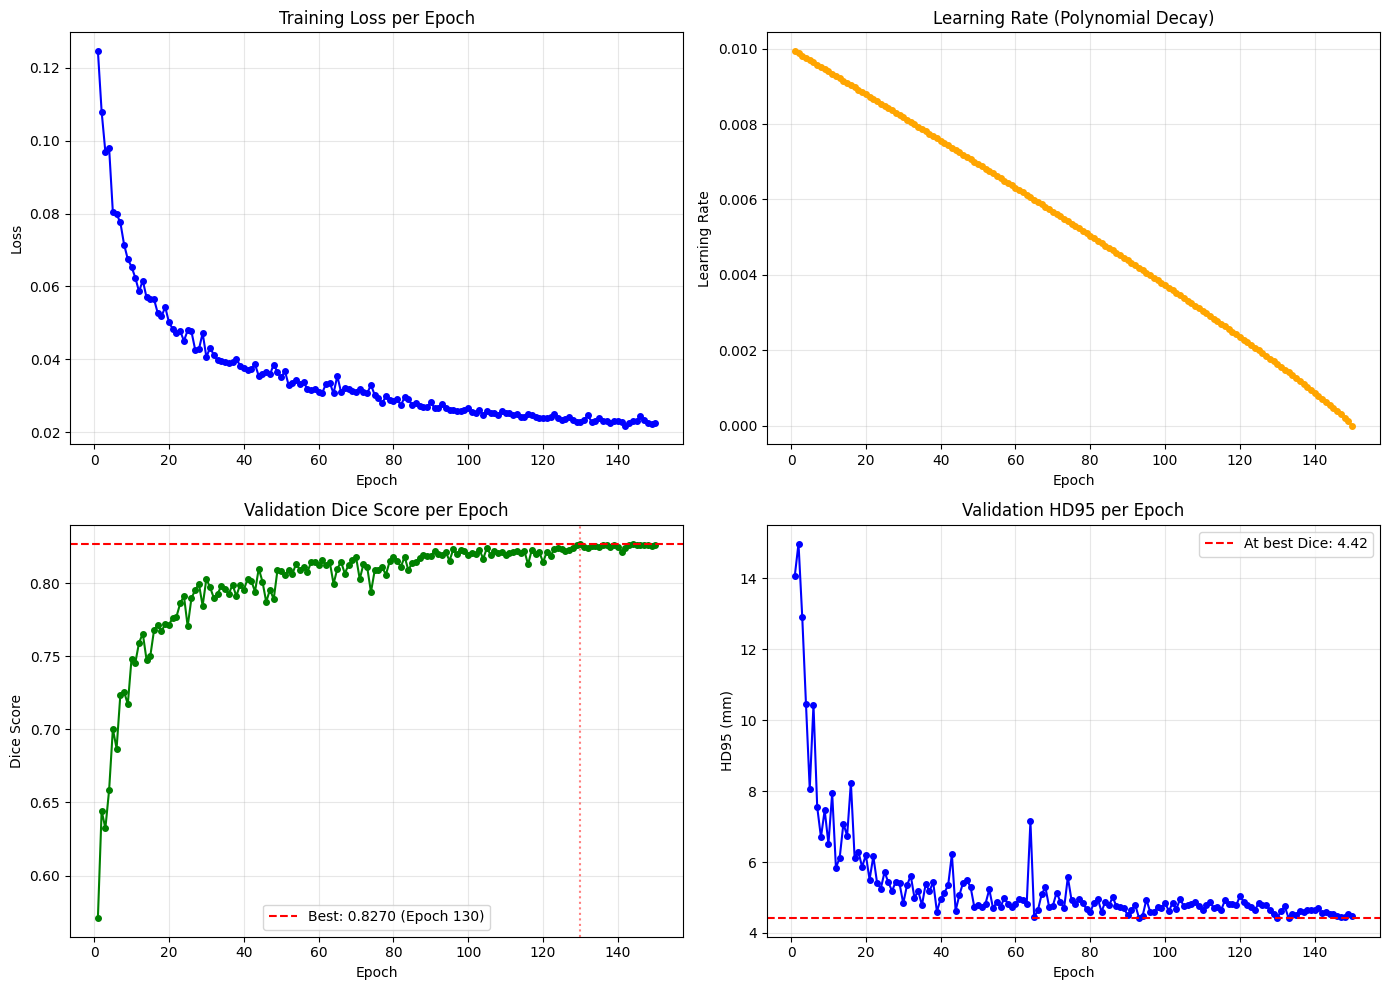


📊 Training history saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/swin_unet_notebook/training_history.png


In [19]:
# Plot training history (epoch-based)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss per epoch
if history['epoch']:
    axes[0, 0].plot(history['epoch'], history['train_loss'], 'b-o', markersize=4)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss per Epoch')
    axes[0, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[0, 1].plot(history['epoch'], history['lr'], 'orange', marker='o', markersize=4)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate (Polynomial Decay)')
    axes[0, 1].grid(True, alpha=0.3)

    # Validation Dice
    axes[1, 0].plot(history['epoch'], history['val_dice'], 'g-o', markersize=4)
    axes[1, 0].axhline(y=best_performance, color='r', linestyle='--', label=f'Best: {best_performance:.4f} (Epoch {best_epoch})')
    axes[1, 0].axvline(x=best_epoch, color='r', linestyle=':', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].set_title('Validation Dice Score per Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation HD95
    axes[1, 1].plot(history['epoch'], history['val_hd95'], 'b-o', markersize=4)
    if best_epoch in history['epoch']:
        best_idx = history['epoch'].index(best_epoch)
        axes[1, 1].axhline(y=history['val_hd95'][best_idx], color='r', linestyle='--', 
                          label=f'At best Dice: {history["val_hd95"][best_idx]:.2f}')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('HD95 (mm)')
    axes[1, 1].set_title('Validation HD95 per Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(experiment_dir / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training history saved to {experiment_dir / 'training_history.png'}")

In [21]:
# ============================================================
# LOAD BEST MODEL & FINAL EVALUATION (SWIN-UNET)
# ============================================================
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd # Dùng pandas để hiển thị bảng kết quả đẹp hơn

# Import lại metrics để đảm bảo không bị lỗi NameError
try:
    from medpy import metric
except ImportError:
    !pip install -q medpy
    from medpy import metric

# Hàm tính metric (Định nghĩa lại để cell này độc lập)
def calculate_metric_percase(pred, gt, spacing=(1.0, 1.0, 1.0)):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        try:
            hd95 = metric.binary.hd95(pred, gt, voxelspacing=spacing)
            asd = metric.binary.asd(pred, gt, voxelspacing=spacing)
        except:
            hd95, asd = 0.0, 0.0
        return dice, hd95, asd
    elif pred.sum() > 0 and gt.sum() == 0:
        return 1, 0, 0
    else:
        return 0, 0, 0

# 1. Load Best Model
experiment_dir = Path(config.experiment_dir)
best_model_path = experiment_dir / "swin_best_model.pth" # Tên file đúng của Swin

model = SwinUnet(config, zero_head=False).to(device)

if best_model_path.exists():
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])
    print(f"✅ Loaded BEST model from epoch {checkpoint['epoch']}")
    print(f"   Best Val Dice: {checkpoint['dice']:.4f}")
else:
    print(f"⚠️ Warning: Best model not found at {best_model_path}. Using current weights.")

model.eval()

# ============================================================
# VISUALIZATION FUNCTION
# ============================================================
def visualize_prediction(image, label, prediction, title="", save_path=None):
    """Vẽ 3 lát cắt đại diện: Đầu, Giữa (có u to nhất), Cuối"""
    # Tìm các slice có tổn thương
    tumor_indices = np.where(label.sum(axis=(1,2)) > 0)[0]
    
    if len(tumor_indices) > 0:
        # Chọn 3 slice: 1 cái đầu dải u, 1 cái giữa (u to nhất), 1 cái cuối dải
        mid_idx = tumor_indices[len(tumor_indices)//2] # Slice giữa (thường u to nhất ở đây)
        # Lấy thêm 2 slice ngẫu nhiên trong vùng u
        slices_to_show = [
            tumor_indices[0], 
            mid_idx, 
            tumor_indices[-1]
        ]
        # Lọc trùng nếu u quá nhỏ (ít slice)
        slices_to_show = sorted(list(set(slices_to_show)))
    else:
        # Nếu không có u, lấy slice giữa volume
        slices_to_show = [image.shape[0]//2]

    fig, axes = plt.subplots(3, len(slices_to_show), figsize=(4 * len(slices_to_show), 10))
    # Xử lý trường hợp chỉ có 1 cột (1 slice)
    if len(slices_to_show) == 1:
        axes = axes[:, np.newaxis]

    for i, slice_idx in enumerate(slices_to_show):
        # 1. Ảnh gốc
        axes[0, i].imshow(image[slice_idx], cmap='gray')
        axes[0, i].set_title(f'Slice {slice_idx}\nImage')
        axes[0, i].axis('off')

        # 2. Ground Truth
        axes[1, i].imshow(image[slice_idx], cmap='gray')
        if label[slice_idx].sum() > 0:
            axes[1, i].contour(label[slice_idx], colors='lime', linewidths=2)
        axes[1, i].set_title('Ground Truth (Green)')
        axes[1, i].axis('off')

        # 3. Prediction
        axes[2, i].imshow(image[slice_idx], cmap='gray')
        if label[slice_idx].sum() > 0:
            axes[2, i].contour(label[slice_idx], colors='lime', linewidths=1, linestyles='--') # GT mờ
        if prediction[slice_idx].sum() > 0:
            axes[2, i].contour(prediction[slice_idx], colors='red', linewidths=2)
        axes[2, i].set_title('Pred (Red) vs GT')
        axes[2, i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# ============================================================
# EVALUATION LOOP (VALIDATION & TEST)
# ============================================================

def evaluate_dataset(dataloader, dataset_name="Validation"):
    print(f"\n📊 Evaluating on {dataset_name} set...")
    print("=" * 60)
    
    results = []
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc=f"Eval {dataset_name}")):
            name = batch["name"][0]
            
            # Lấy dữ liệu raw (bỏ batch & channel)
            image_vol = batch["image"][0, 0].cpu().numpy() # (D, H, W)
            label_vol = batch["label"][0].cpu().numpy()    # (D, H, W)
            spacing = batch["spacing"][0].cpu().numpy()    # (3,)
            
            prediction_vol = np.zeros_like(label_vol)
            
            # Slice-by-slice Inference
            for ind in range(image_vol.shape[0]):
                slice_img = image_vol[ind, :, :]
                h, w = slice_img.shape
                
                # Resize image (Order 1 for linear interpolation)
                scale_h = config.img_size / h
                scale_w = config.img_size / w
                slice_resized = zoom(slice_img, (scale_h, scale_w), order=1)
                
                input_tensor = torch.from_numpy(slice_resized).unsqueeze(0).unsqueeze(0).float().to(device)
                
                # Model Predict
                out = model(input_tensor)
                out = torch.argmax(torch.softmax(out, dim=1), dim=1).squeeze().cpu().numpy()
                
                # Resize prediction back (Order 0 for nearest neighbor - giữ nguyên class)
                pred_resized = zoom(out, (1/scale_h, 1/scale_w), order=0)
                
                # Fix size mismatch due to rounding
                if pred_resized.shape != (h, w):
                    from skimage.transform import resize
                    pred_resized = resize(pred_resized, (h, w), order=0, mode='constant', preserve_range=True)
                
                prediction_vol[ind, :, :] = pred_resized
            
            # Calculate Metrics
            dice, hd95, asd = calculate_metric_percase(prediction_vol == 1, label_vol == 1, spacing)
            
            results.append({
                'Case': name,
                'Dice': dice,
                'HD95': hd95,
                'ASD': asd
            })
            
            # Visualize vài case đầu tiên
            if i < 3: 
                viz_path = experiment_dir / f"viz_{dataset_name}_{name}.png"
                visualize_prediction(image_vol, label_vol, prediction_vol, 
                                     title=f"{name} | Dice: {dice:.4f}", save_path=viz_path)

    # Thống kê kết quả
    df = pd.DataFrame(results)
    print("\n" + "=" * 60)
    print(f"📊 {dataset_name.upper()} RESULTS SUMMARY")
    print("=" * 60)
    print(df.describe().loc[['mean', 'std', 'min', 'max']])
    
    # Save CSV
    csv_path = experiment_dir / f"{dataset_name.lower()}_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Detailed results saved to {csv_path}")
    print(f"✅ Visualizations saved to {experiment_dir}")
    
    return df

# 1. Chạy trên Validation Set
val_results = evaluate_dataset(val_loader, "Validation")

# 2. Chạy trên Test Set (nếu có)
test_dir = Path(config.output_root) / "test_set"
if test_dir.exists() and len(list(test_dir.glob("*.h5"))) > 0:
    test_dataset = H5VolumeDataset(test_dir)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
    test_results = evaluate_dataset(test_loader, "Test")
else:
    print("\n⚠️ Test set not found or empty. Skipping test evaluation.")

✅ Loaded BEST model from epoch 130
   Best Val Dice: 0.8270

📊 Evaluating on Validation set...


Eval Validation: 100%|██████████| 16/16 [00:49<00:00,  3.11s/it]



📊 VALIDATION RESULTS SUMMARY
          Dice       HD95       ASD
mean  0.826974   3.094930  0.529008
std   0.070797   4.744867  0.319967
min   0.675939   0.662983  0.186215
max   0.940057  20.309748  1.424293

✅ Detailed results saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/swin_unet_notebook/validation_results.csv
✅ Visualizations saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/swin_unet_notebook

📊 Evaluating on Test set...


Eval Test: 100%|██████████| 32/32 [01:16<00:00,  2.38s/it]


📊 TEST RESULTS SUMMARY
          Dice      HD95       ASD
mean  0.830877  1.965972  0.531590
std   0.048029  1.014648  0.291270
min   0.742860  0.468800  0.194982
max   0.953446  4.062400  1.422807

✅ Detailed results saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/swin_unet_notebook/test_results.csv
✅ Visualizations saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/swin_unet_notebook
